In [20]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
#%cd /Users/Henning/PycharmProjects/missing-value-handling-in-carts
import matplotlib.pyplot as plt
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response

idx = pd.IndexSlice

/home/heza7322/PycharmProjects/missing-value-handling-in-carts


In [21]:
data_folder = 'example_notebooks/data_to_use'
data_sets = ['auto_mpg','balance_scale','black_friday','boston_housing','cement','iris','kr_vs_kp',
             'lymphography','titanic','wine_quality']

tree_types = ['majority','mia','weighted','trinary']
missingnesses = ['all','test']
missing_probs = list(np.arange(10)/10)+[0.99]
index = pd.MultiIndex.from_product([data_sets,missingnesses,tree_types],names = ['file_name','missingness','tree_type'])
errors = pd.DataFrame(index = index, columns = missing_probs)

max_depths = np.arange(1,15)
min_samples_leaf = 20

for data_set in data_sets:
    print(f'Starting data set: {data_set}')
    # Load data
    df = pd.read_csv(f'{data_folder}/{data_set}.csv',index_col = 0)
    if data_set == 'black_friday':
        df.drop('Occupation',axis=1,inplace=True)
    features = [column for column in df.columns if column!='y']
    df.reset_index(inplace = True,drop=True)

    if df.dtypes['y'] == 'int':
        df['y'] = df['y'].astype(float)

        df = df.sample(100)

    # Test train split
    n = len(df)
    np.random.seed(11)
    df['test'] = False
    index_train = np.random.choice(df.index,int(n*0.2))
    df.loc[index_train,'test'] = True

    X_train = df.loc[~df['test'],features]
    y_train = df.loc[~df['test'],'y']
    X_test  = df.loc[df['test'],features]
    y_test  = df.loc[df['test'],'y']

    # Get best max depth
    losses = pd.Series(index = np.arange(0,max(max_depths)), dtype = float)
    losses[0] = calculate_loss(y_test)

    for max_depth in max_depths:
        tree = BinaryTree(max_depth = max_depth, min_samples_leaf= min_samples_leaf)
        tree.fit(X_train, y_train)
        if y_test.dtype == float:
            y_hat = tree.predict(X_test)
            loss = calculate_loss(y_test,y_hat = y_hat)
        else:
            y_prob = tree.predict(X_test, prob = True)
            loss = calculate_loss(y_test,y_prob = y_prob)

        losses.loc[max_depth] = loss
        if max_depth>1:
            if losses.loc[max_depth]>=losses.loc[max_depth-1]:
                break

    max_depth = losses.idxmin()
    print(f'max depth: {max_depth}')

    # Set up trees
    tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf, missing_rule='majority'),
                  'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
                  'trinary':  TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
                  'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}

    dfs = {0: df.copy()}
    n_to_remove = [0]
    for i in range(1,len(missing_probs)):
        n_to_remove += [int(missing_probs[i]*n) - sum(n_to_remove[:i])]
        dfs[i] = dfs[i-1].copy()
        for feature in features:
            to_remove = dfs[i].loc[~dfs[i][feature].isna()].sample(n_to_remove[i]).index
            dfs[i].loc[to_remove,feature] = np.nan

    # Fit trees
    trees = {}
    for i,missing_prob in enumerate(missing_probs):
        X_train = dfs[i].loc[~dfs[i]['test'],features]
        y_train = dfs[i].loc[~dfs[i]['test'],'y']
        X_test  = dfs[i].loc[dfs[i]['test'],features]
        y_test  = dfs[i].loc[dfs[i]['test'],'y']
        trees[i] = {}
        for tree_name in tree_types:
            trees[i][tree_name] = copy.deepcopy(tree_types[tree_name])
            trees[i][tree_name].fit(X_train,y_train)
            if y_test.dtype == float:
                y_hat = trees[i][tree_name].predict(X_test)
                loss = calculate_loss(y_test, y_hat = y_hat)
            else:
                y_prob = trees[i][tree_name].predict(X_test, prob = True)
                loss = calculate_loss(y_test, y_prob = y_prob)
            errors.loc[idx[data_set,'all',tree_name],missing_prob] = loss

        print(f'missingness {missing_prob} completed')

    # Missingness of different frequencies ONLY in test data
    for i,missing_prob in enumerate(missing_probs):
        X_test  = dfs[i].loc[dfs[i]['test'],features]
        y_test  = dfs[i].loc[dfs[i]['test'],'y']
        for tree_name in tree_types:
            if y_test.dtype == float:
                y_hat = trees[0][tree_name].predict(X_test)
                loss = calculate_loss(y_test, y_hat = y_hat)
            else:
                y_prob = trees[0][tree_name].predict(X_test, prob = True)
                loss = calculate_loss(y_test, y_prob = y_prob)
            errors.loc[idx[data_set,'test',tree_name],missing_prob] = loss


Starting data set: auto_mpg
max depth: 4
missingness 0.0 completed
missingness 0.1 completed
missingness 0.2 completed
missingness 0.3 completed
missingness 0.4 completed
missingness 0.5 completed
missingness 0.6 completed
missingness 0.7 completed
missingness 0.8 completed
missingness 0.9 completed
missingness 0.99 completed
Starting data set: balance_scale
max depth: 5
missingness 0.0 completed
missingness 0.1 completed
missingness 0.2 completed
missingness 0.3 completed
missingness 0.4 completed
missingness 0.5 completed
missingness 0.6 completed
missingness 0.7 completed
missingness 0.8 completed
missingness 0.9 completed
missingness 0.99 completed
Starting data set: black_friday
max depth: 0
missingness 0.0 completed
missingness 0.1 completed
missingness 0.2 completed
missingness 0.3 completed
missingness 0.4 completed
missingness 0.5 completed
missingness 0.6 completed
missingness 0.7 completed
missingness 0.8 completed
missingness 0.9 completed
missingness 0.99 completed
Startin

KeyboardInterrupt: 

In [22]:
errors_norm = pd.DataFrame(index = errors.index, columns = errors.columns)
for data_set in data_sets:
    for missingness in missingnesses:
        errors_norm.loc[idx[data_set,missingness,:],:] = errors.loc[idx[data_set,missingness,:],:].div(errors.loc[idx[data_set,missingness,:],0],axis=0)

In [23]:
errors_norm_avg = errors_norm.groupby(['missingness','tree_type']).mean()

<Axes: >

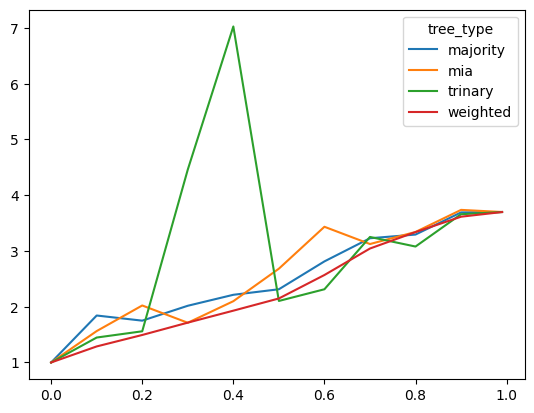

In [27]:
errors_norm_avg.loc[idx['all',:]].T.plot()

iris


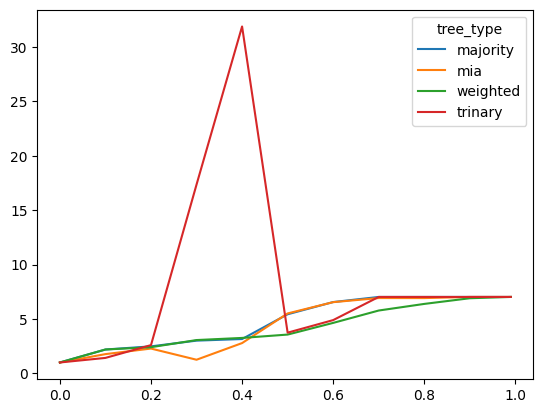

In [42]:
data_set = data_sets[5]
print(data_set)
errors_norm.loc[idx[data_set,'all']].T.plot();

<Axes: >

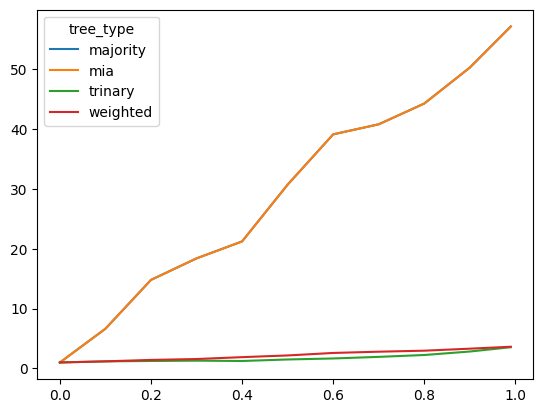

In [25]:
errors_norm_avg.loc[idx['test',:]].T.plot()